# Creating the Bathymetry

In this notebook, we will explore how to create the grid of a model.

First, import packages to re-create and visualize the model grid here:


In [15]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
from scipy.interpolate import griddata

import eccoseas.downscale.bathymetry as edb

## Bathymetry Source File

To generate the bathymetry for the model, first obtain a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/


## Interpolating Bathymetry onto the Model Domain

Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.


In [16]:
# read in the bathymetry grid
PROJ_ROOT = Path("..").resolve()
DATA_DIR = PROJ_ROOT / "data"
INPUT_DIR = PROJ_ROOT / "input"

In [17]:
BATHY_FILE = DATA_DIR / "GEBCO_2025_sub_ice.nc"
BATHY_DS = Dataset(BATHY_FILE)

# slicing
STEP = 10
BATHY_DS_LON = BATHY_DS.variables["lon"][::STEP]
BATHY_DS_LAT = BATHY_DS.variables["lat"][::STEP]
BATHY_DS_ELEV = BATHY_DS.variables["elevation"][::STEP, ::STEP]

BATHY_DS.close()

# create a meshgrid of the lon and lat
DS_LON_MG, DS_LAT_MG = np.meshgrid(BATHY_DS_LON, BATHY_DS_LAT)

## Recreate the Model Grid


In [18]:
DEL_X = 0.5
DEL_Y = 0.5
XG_ORIGIN = -180
YG_ORIGIN = -90
N_COLS = 720
N_ROWS = 360

XC = np.arange(XG_ORIGIN + DEL_X / 2, XG_ORIGIN + N_COLS * DEL_X + DEL_X / 2, DEL_X)
YC = np.arange(YG_ORIGIN + DEL_Y / 2, YG_ORIGIN + N_ROWS * DEL_Y + DEL_Y / 2, DEL_Y)
XC_MG, YC_MG = np.meshgrid(XC, YC)
print("Double check shape:", np.shape(XC_MG), np.shape(YC_MG))

Double check shape: (720,) (360,)


In [19]:
# interpolate the gebco data onto the model grid
bathy_model = griddata(
    np.column_stack([DS_LON_MG.ravel(), DS_LAT_MG.ravel()]),
    BATHY_DS_ELEV.ravel(),
    (XC_MG, YC_MG),
    method="nearest",
)

# set points on land to 0
bathy_model[bathy_model > 0] = 0

## Visualize the Bathymetry Grid

Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:


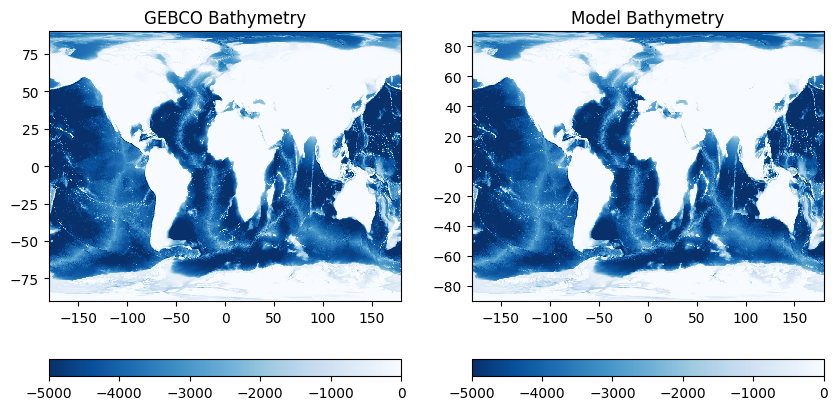

In [21]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
C = plt.pcolormesh(DS_LON_MG, DS_LAT_MG, BATHY_DS_ELEV, vmin=-5000, vmax=0, cmap="Blues_r")
plt.colorbar(C, orientation="horizontal")
plt.title("GEBCO Bathymetry")

plt.subplot(1, 2, 2)
C = plt.pcolormesh(XC_MG, YC_MG, bathy_model, vmin=-5000, vmax=0, cmap="Blues_r")
plt.colorbar(C, orientation="horizontal")
plt.title("Model Bathymetry")

plt.show()

## Check for Isolated Regions

One potential problem that can be encountered in ocean models occurs with isolated regions


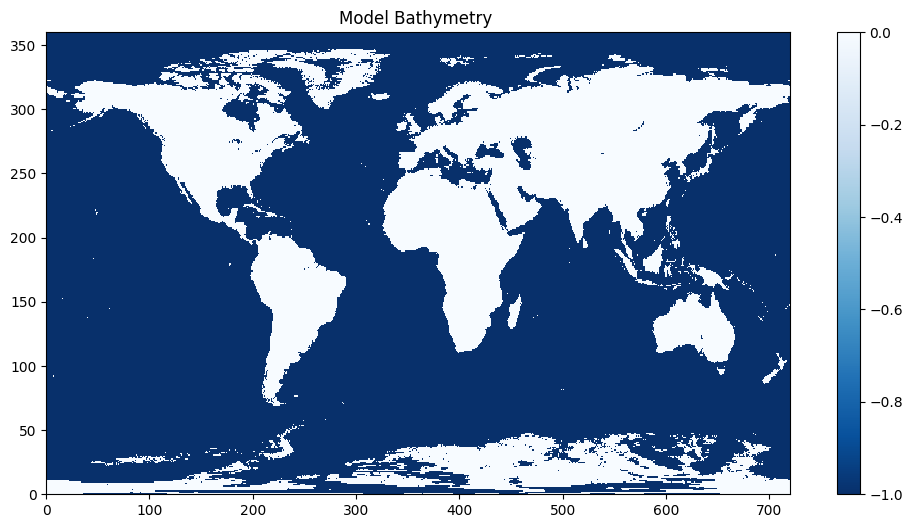

In [22]:
plt.figure(figsize=(12, 6))

C = plt.pcolormesh(bathy_model, vmin=-1, vmax=0, cmap="Blues_r")
plt.colorbar(C)
plt.title("Model Bathymetry ")

plt.show()

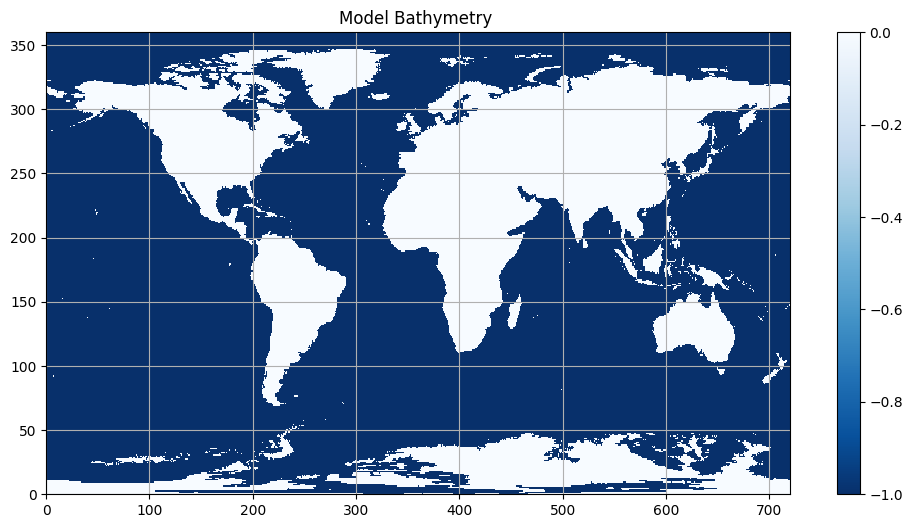

In [24]:
bathy_model = edb.fill_unconnected_model_regions(
    bathy_model, central_wet_row=100, central_wet_col=100
)

plt.figure(figsize=(12, 6))

C = plt.pcolormesh(bathy_model, vmin=-1, vmax=0, cmap="Blues_r")
plt.colorbar(C)
plt.grid()
plt.title("Model Bathymetry ")

plt.show()

In [25]:
OUTPUT_FILE = INPUT_DIR / "earth_bathymetry.bin"
bathy_model.ravel("C").astype(">f4").tofile(str(OUTPUT_FILE))